# Štatistické testovanie hypotéz

URL https://github.com/FIIT-IAU/

**Chceme overiť, či má počet valcov motora vplyv na spotrebu.**

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing

In [2]:
cars = pd.read_csv('data/auto-mpg.data', 
                   delim_whitespace=True, 
                   names = ['mpg', 'cylinders', 'displacement','horsepower',
                            'weight', 'acceleration', 'model_year', 'origin', 'name'],
                   na_values='?')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [3]:
cars.cylinders.unique()

array([8, 4, 6, 3, 5])

In [4]:
cars.cylinders.value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

<AxesSubplot: xlabel='cylinders', ylabel='mpg'>

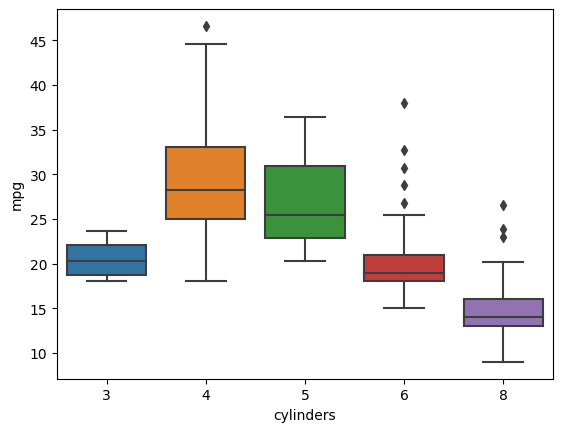

In [5]:
sns.boxplot(x='cylinders', y='mpg', data=cars)

Vidíme, že v datasete máme viacero typov motora (podľa počtu valcov). Už z vizualizácie pomocou boxplotov vidíme, že existuje vzťah medzi počtom valcov a spotrebou (vyjadrenou ako počet míľ, ktoré je auto schopné prejsť na jeden galón paliva, t. j. miles per gallon, `mpg`).

Máme viacero možností, ako otestovať typ tohto vzťahu:

* môžeme sa pozrieť, či je medzi týmito dvomi atribútmi korelácia
* môžeme skúsiť *nafitovať* (napr. lineárny) regresný model
* môžeme otestovať rozdiely medzi priemermi skupín podľa počtu valcov.

My sa pozrieme na tú poslednú možnosť. Otestujme či je **rozdiel medzi spotrebou 6 a 8-valcových motorov štatisticky signifikantný (a teda nie je napr. len daný náhodou alebo chybou)**.

Určímte si teda naše hypotézy nasledovne:

**$H_0$ (nulová hypotéza)**: Spotreba 6-valcových motorov **je** v priemere **rovnaká** ako spotreba 8-valcových

**$H_1 = H_A$ (alternatívna hypotéza)**: Spotreba 6-valcových motorov **je** v priemere **iná/väčšia/menšia** ako spotreba 8-valcových


<AxesSubplot: xlabel='cylinders', ylabel='mpg'>

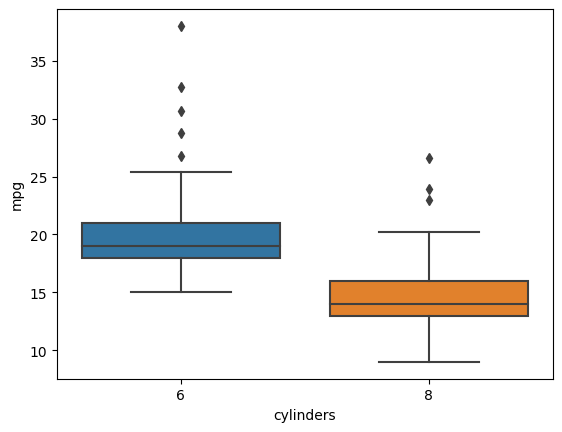

In [6]:
sns.boxplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 6) | (cars.cylinders == 8)])

- Nejaký rozdiel tam je, to vidíme aj na základe vizuálneho porovnania. Ak chceme overiť, či je signifikantný, potrebujeme použiť štatistický test.
- Máme dve skupiny, vťah medzi nimi je nezávislý (motor má vždy buď 6 alebo 8 valcov). Do úvahy teda pripadá *t-test* alebo *Mann-Whitenyho U test*. Volíme t-test, ak sú splnené jeho predpoklady (dáta pochádzajú z normálnych distribúcií a tie majú aj rovnaké (prípadne podobné) variancie.

## Overenie predpokladov

### Predpoklad normálnosti rozdelenia

Normálnosť rozdelenia si vieme overiť vizuálne pomocou histogramu, prípadne pomocou tzv. QQ-grafu.

In [7]:
mpg6 = cars.loc[cars.cylinders == 6, 'mpg']

In [8]:
mpg6.describe()

count    84.000000
mean     19.985714
std       3.807322
min      15.000000
25%      18.000000
50%      19.000000
75%      21.000000
max      38.000000
Name: mpg, dtype: float64

<AxesSubplot: xlabel='mpg', ylabel='Count'>

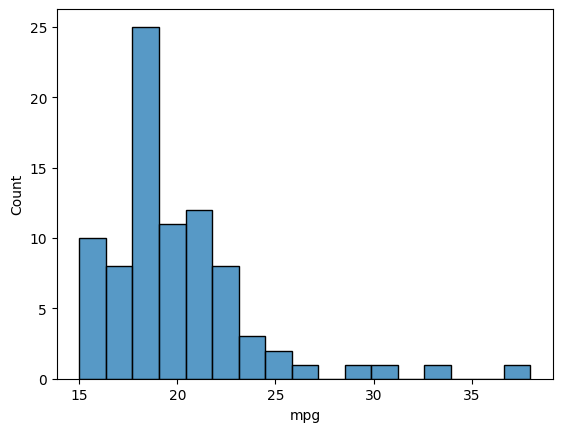

In [9]:
# sns.distplot(mpg6)
sns.histplot(mpg6)

Vo vzorke sa nachádzajú vychýlené hodnoty. Najjednoduchšou metódou na identifikáciu vychýlených hodnôt (outlierov) je označiť za vychýlenú hodnotu pozorovanie, ktoré sa odlišuje o viac ako 1,5 násobok medzikvartilového rozdelenia od horného, resp. dolného kvartilu.

In [10]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [11]:
mpg6_out = identify_outliers(mpg6)
mpg6_out

306    28.8
307    26.8
333    32.7
360    30.7
387    38.0
Name: mpg, dtype: float64

In [12]:
mpg6 = mpg6.drop(mpg6_out.index)

<AxesSubplot: xlabel='mpg', ylabel='Count'>

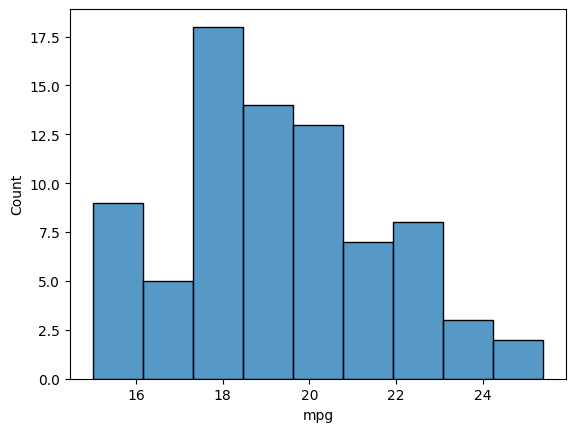

In [13]:
# sns.distplot(mpg6)
sns.histplot(mpg6)

In [14]:
mpg8 = cars.loc[cars.cylinders == 8, 'mpg']

In [15]:
mpg8.describe()

count    103.000000
mean      14.963107
std        2.836284
min        9.000000
25%       13.000000
50%       14.000000
75%       16.000000
max       26.600000
Name: mpg, dtype: float64

In [16]:
mpg8_out = identify_outliers(mpg8)
mpg8_out

298    23.0
300    23.9
364    26.6
Name: mpg, dtype: float64

In [17]:
mpg8 = mpg8.drop(mpg8_out.index)

<AxesSubplot: xlabel='mpg', ylabel='Count'>

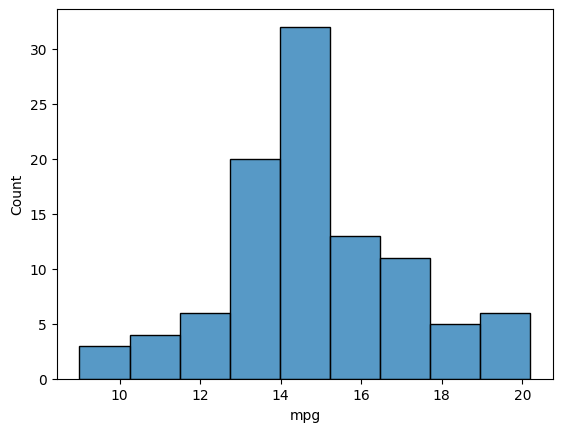

In [18]:
# sns.distplot(mpg8)
sns.histplot(mpg8)

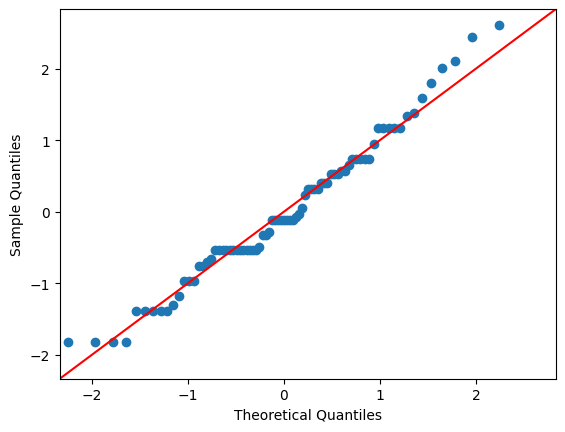

In [19]:
_ = sm.ProbPlot(mpg6, fit=True).qqplot(line='45')

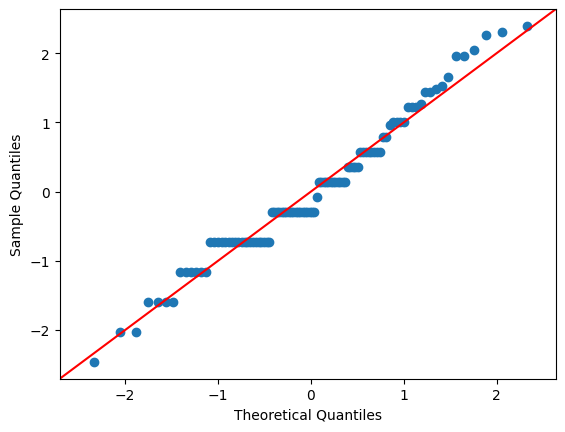

In [20]:
_ = sm.ProbPlot(mpg8, fit=True).qqplot(line='45')

QQ-plot je vizuálna metóda na určenie, či dve dátove sady pochádzajú z rovnakého rozdelenia. Najčastejšie sa porovnáva rozdelenie vzorky s teoretickým normálnym rozdelením. Bod na grafe zobrazuje hodnotu kvantilu v prvom a druhom porovnávanom datasete.

#### Na aké otazky vie QQ-plot odpovedať?

* Pochadzajú dve skupiny pozorovaní z rovnakého rozdelenia?
* Pochádza pozorovaná vzorka z testovaného teoretického rozdelenia (napr. normálneho)?
* Majú rozdelenia podobné vlastnosti asymetrie (skewness) a špicatosti (kurtosis)?

## Shapiro-Wilkov test normálnosti

Na overenie normálnosti vieme použiť aj **Shapiro-Wilkov test**, ktorý testuje nulovú hypotézu, že dáta pochádzajú z normálneho rozdelenia. Ak je $p < 0,05$, nulovú hypotézu $H_0$ zamietame a dáta pravdepodobne pochádzajú z iného ako normálneho rozdelenia. Ak je $p > 0,05$, nulovú hypotézu $H_0$ nezamietame, teda na základe dát nemôžeme prehlásiť, že by dáta pochádzali z iného, ako normálneho rozdelenia.

In [21]:
stats.shapiro(mpg6)

ShapiroResult(statistic=0.9750955104827881, pvalue=0.12479004263877869)

In [22]:
stats.shapiro(mpg8)

ShapiroResult(statistic=0.9733667373657227, pvalue=0.04022931680083275)

Na základe výsledkov testu sa zdá, že vzorka aút so 6-valcovými motormi pochádza z normálneho rozdelenia, vzorka s 8-valcovými motormi nie. Mali by sme teda použiť neparametrickú verziu t-testu, t. j. **Mann-Whitneyho U-test** (hoci t-test je nad istý počet vzoriek relatívne robustný na mierne odchýlky od predpokladu normálnosti).

## Podobnosť variancie

Druhým predpokladom použitia t-testu je rovnosť variancií (hoci existuje variant t-testu, ktorý vie pracovať aj s dátami s nerovnakou varianciou). Hoci sme neoverili predpoklad normálnosti rozdelení, pozrime sa na ich variancie. 

Na otestovanie podobnosti variancií sa používa **Levenov test**. Testuje nulovú hypotézu $H_0$, že všetky vstupné vzorky pochádzajú z rozdelení s rovnakými varianciami. Ak $H_0$ nezamietame ($p > 0,05$), znamená to, že na základe dát nemôžeme prehlásiť, že by vzorky pochádzali z distribúcií s rôznymi varianciami.

In [23]:
stats.levene(mpg6, mpg8)

LeveneResult(statistic=0.044821392421680255, pvalue=0.8325763705509353)

Na základe výsledku testu sa zdá, že vzorky pochádzajú z rozdelení s rovnakou varianciou.

## Studentov t-test vs. Mann-Whiteneyho U-test

Keďže neboli splnené predpoklady t-testu, mali by sme použiť jeho neparametrickú verziu. Ak by boli splnené, použili by sme funkciu `scipy.stats.ttest_ind`.

In [24]:
stats.mannwhitneyu(mpg6, mpg8)

MannwhitneyuResult(statistic=7232.0, pvalue=1.240538694001431e-21)

Keďže $p < 0,001$, pravdepodobnosť chyby 1. rádu (že $H_0$ je pravdivá a my ju zamietame) je menej ako 1 promile. Našu nulovú hypotézu $H_0$ teda zamietame v prospech alternatívnej hypotézy $H_A$. Rozdiel v spotrebe medzi 6 a 8-valcovými motormi je štatisticky signifikantný.

Môžeme si vizualizovať rozdiel medzi dvomi priemermi - často sa zobrazujú pomocou stĺpcových diagramov spolu s *intervalmi spoľahlivosti*, ktoré nám hovoria, že s N% pravdepodobnosťou (najčastejšie sa používa 95) sa skutočná hodnota priemeru bude nachádzať niekde v danom intervale.

In [25]:
sms.DescrStatsW(mpg6).tconfint_mean()

(18.73322498793141, 19.793357290549597)

In [26]:
sms.DescrStatsW(mpg8).tconfint_mean()

(14.216826054523317, 15.137173945476682)

<AxesSubplot: xlabel='cylinders', ylabel='mpg'>

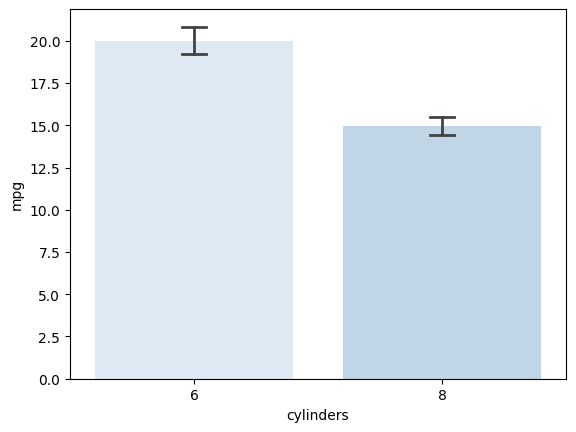

In [27]:
sns.barplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 8) | (cars.cylinders == 6)], 
            capsize=0.1, errwidth=2, palette=sns.color_palette("Blues"))